## Descriptive statistics

The goal is to picture what is happening in the IBTrACS during the intensification phase, when all storms are temporally calibrated on the LMI (Lifetime Maximum Intensity).

NB: CSV files for AnDA are also prepared in this notebook.

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw', 'storm_speed', 'storm_dir', 'numobs'] 
additional_info    = ['sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'fcor_boost' : 1,         
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'save_path':     '/home/arthur/results/TCsLifeMonitFromObs/descriptive_stats/',
    'save_csv_path': '/home/arthur/scripts/TCsLifeMonitFromObs/AnDA/AnDA_data/IBTrACS_V4/',
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])

ds_ibt                  = ds_ibt_raw[params_of_interest]
ds_ibt[additional_info] = ds_ibt_raw[additional_info].astype(str, copy=False) # Convert byte arrays to strings
# ds_ibt_raw

In [5]:
# ### FILTERS
# # Convert to m/s and km units
# ds_ibt['usa_wind']    *= 0.5144
# ds_ibt['storm_speed'] *= 0.5144
# ds_ibt['usa_r34']     *= 1.852
# ds_ibt['usa_rmw']     *= 1.852

# ### 1) FILTERS BY YEAR, EMPTY R34, CATEGORY, RMAX INTERESTING TIME SERIES
# # By year
# start_date = np.datetime64('2000-01-01')
# fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
# ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# # Average by quadrant (R34 assumption)
# # ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True) # Relax this assumption to study the asymmetry
# # By category
# for s in tqdm(range(len(ds_ibt['storm']))):
#     da = ds_ibt.isel(storm=s)['usa_wind']
#     if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
#         ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
# for s in tqdm(range(len(ds_ibt['storm']))):
#     da = ds_ibt.isel(storm=s)['usa_rmw']
#     # Longest valid sequence
#     # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
#     #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
#     # Number of valid values
#     if np.count_nonzero(~np.isnan(da)) < 24: # Count the number otimestep_since_17msf valid usa_rmw values and filter it out if less than 24 values
#         ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# # Drop NaNs
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

# # Add Time step since 17.5 m/s have been achieved
# ds_ibt['timestep_since_17ms'] = ds_ibt['usa_lon'] * 0
# ds_ibt['initial_r17']         = ds_ibt['numobs'] * 0
# for s in tqdm(range(len(ds_ibt.storm))):
#     ds = ds_ibt.isel(storm=s)
#     timestep_of_17ms = int(np.where(ds['usa_wind'] > 17.5)[0][0])
#     initial_r17      = float(ds_ibt.isel(storm=-1)['usa_r34'].mean(dim='quadrant', skipna=True)[timestep_of_17ms + 1]) # t + 1 to ensure a value is defined
#     ds_ibt['timestep_since_17ms'][s] = ds.date_time - timestep_of_17ms
#     ds_ibt['initial_r17'][s]         = initial_r17  

# print("Total samples after (1): ", len(ds_ibt['storm']))

# ### 2) FINAL DATASET
# ### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# # Both for RMW and R34
# life_cyc_percent_thresh = 0.6

# for s in tqdm(range(len(ds_ibt['storm']))):
#         ds      = ds_ibt.isel(storm=s)
#         # Compute life cycle length
#         cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
#         for param in ['usa_r34', 'usa_rmw']:
#         # for param in ['usa_rmw']:
#             # Compute length of longest valid sequence
#             val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
#             if val_len < life_cyc_percent_thresh * cyc_len:
#                 # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
#                 ds[param] *= np.nan
                
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

# print("Total samples after (2): ", len(ds_ibt['storm'])) 

# ### 3) ADD CORIOLIS
# ds_ibt['fcor'] = f.coriolis(np.abs(ds_ibt['usa_lat'])) * PARAMS['fcor_boost']
                
# ### 4) FLIP TCs of Southern hemisphere
# ### Take the symmetric with respect to Equator
# ### So storm_dir = PI - storm_dir
# ds_ibt.where(ds_ibt['lat'] < 0)['storm_dir'] = 180 - ds_ibt['storm_dir']
# # Then project to (u, v) ref.
# ds_ibt['u_trans'] = ds_ibt['storm_speed'] * np.sin(np.deg2rad(ds_ibt['storm_dir']))
# ds_ibt['v_trans'] = ds_ibt['storm_speed'] * np.cos(np.deg2rad(ds_ibt['storm_dir']))
# # plt.hist(np.array(ds_ibt['u_trans']).flatten()) # Check gaussianity

# ### 5) COMPUTE RMAX_CK22
# ds_ibt['rmax_ck22'] = f.get_rmax_ck22(
#     Vmax=ds_ibt['usa_wind'], R17=ds_ibt['usa_r34'], fcor=f.coriolis(np.abs(ds_ibt['usa_lat'])), 
#     intercept=0.459, coef1=0.00534, coef2=-0.00337
# ) / 1000

In [6]:
# ### SAVE
# ds_ibt.to_netcdf(PATHS['save_path'] + 'ds_ibtracs_ALL.nc')

In [7]:
# ### OPEN
ds_ibt = xr.open_dataset(PATHS['save_path'] + 'ds_ibtracs_ALL.nc')
# ds_ibt

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


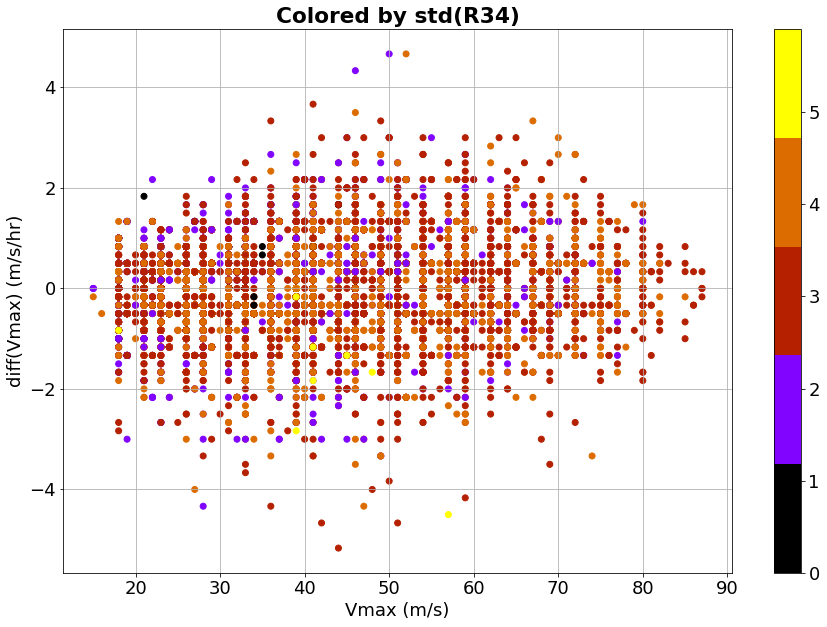

In [8]:
cmap       = cm.get_cmap('gnuplot', 5)

vmaxs      = np.array(ds_ibt['usa_wind'])
vmaxs_diff = np.gradient(vmaxs, 3, axis=1)

plt.scatter(vmaxs, vmaxs_diff, c=np.log(ds_ibt['usa_r34'].std(dim='quadrant', skipna=True)), cmap=cmap)

plt.title('Colored by std(R34)', weight='bold')
plt.xlabel('Vmax (m/s)');plt.ylabel('diff(Vmax) (m/s/hr)')
plt.grid();plt.colorbar()

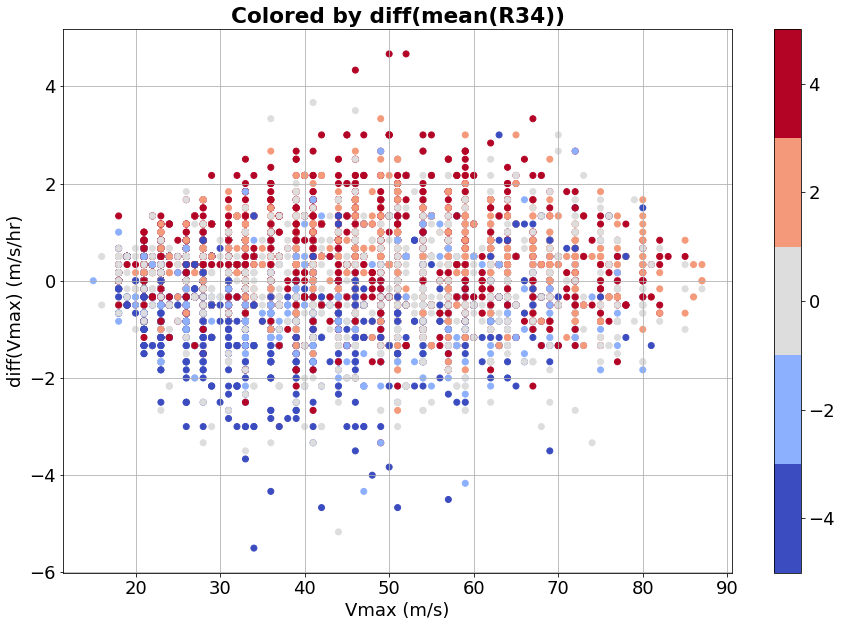

In [9]:
cmap       = cm.get_cmap('coolwarm', 5)

vmaxs      = np.array(ds_ibt['usa_wind'])
vmaxs_diff = np.gradient(vmaxs, 3, axis=1)
r34s       = np.array(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True))
r34s_diff  = np.gradient(r34s, 3, axis=1)

plt.scatter(vmaxs, vmaxs_diff, c=r34s_diff, vmin=-5, vmax=5, cmap=cmap)

plt.title('Colored by diff(mean(R34))', weight='bold')
plt.xlabel('Vmax (m/s)');plt.ylabel('diff(Vmax) (m/s/hr)')
plt.grid();plt.colorbar()

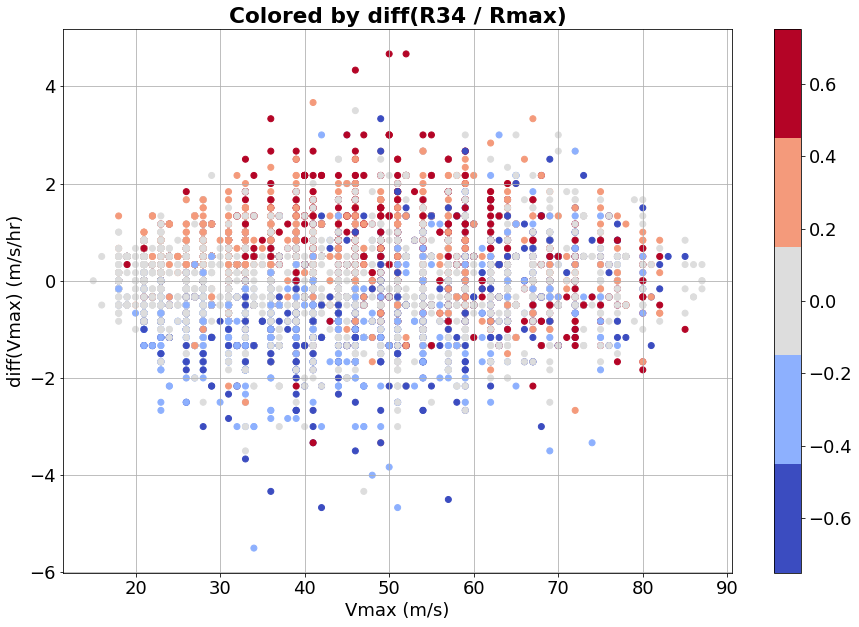

In [10]:
cmap       = cm.get_cmap('coolwarm', 5)

vmaxs      = np.array(ds_ibt['usa_wind'])
vmaxs_diff = np.gradient(vmaxs, 3, axis=1)
r34_rmaxs  = np.array(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True) / ds_ibt['usa_rmw'])
r34_rmaxs_diff = np.gradient(r34_rmaxs, 3, axis=1)

plt.scatter(vmaxs, vmaxs_diff, c=r34_rmaxs_diff, vmin=-0.75, vmax=0.75, cmap=cmap)

plt.title('Colored by diff(R34 / Rmax)', weight='bold')
plt.xlabel('Vmax (m/s)');plt.ylabel('diff(Vmax) (m/s/hr)')
plt.grid();plt.colorbar()

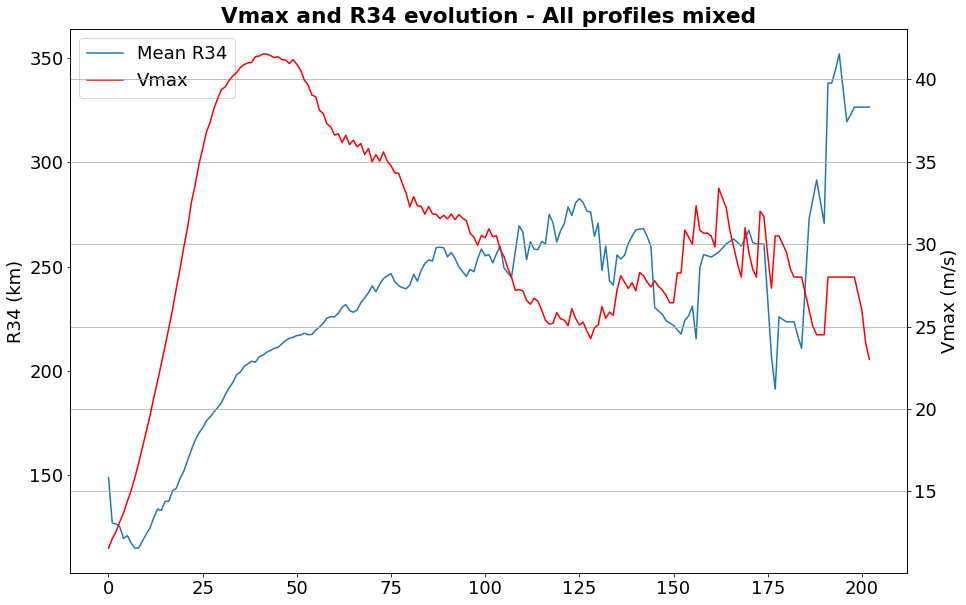

In [11]:
# BRUTE-FORCE APPROACH
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - All profiles mixed', weight='bold')
l1  = ax1.plot(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True).mean(dim='storm', skipna=True), c='tab:blue', label='Mean R34')
l2  = ax2.plot(ds_ibt['usa_wind'].mean(dim='storm', skipna=True), c='r', label='Vmax')
plt.xlabel('datetime');ax1.set_ylabel('R34 (km)');ax2.set_ylabel('Vmax (m/s)')
plt.grid();ax1.legend(l1 + l2, [l1[0].get_label(), l2[0].get_label()], loc=0)

In [12]:
list_of_vars = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'mean_r34', 'usa_rmw', 'storm_dir', 'storm_speed', 'lon', 'lat', 'timestep_since_17ms',\
               'basin', 'fcor', 'u_trans', 'v_trans', 'rmax_ck22', 'mean_rmax_ck22',
               ]

### COMPUTE v* AND t*
ds_ibt['v_star']     = ds_ibt['usa_wind'].max(dim='date_time', skipna=True)
v_star_idxs          = ds_ibt['usa_wind'].argmax(dim='date_time', skipna=True)
ds_ibt['t_star_idx'] = v_star_idxs
ds_ibt['t_star']     = ds_ibt['time'][:, v_star_idxs]

### COMPUTE DELTA
ds_ibt['delta']           = ds_ibt['numobs'] * 0
ds_ibt['delta_left_idx']  = ds_ibt['numobs'] * 0
ds_ibt['delta_right_idx'] = ds_ibt['numobs'] * 0
ds_ibt['first_valid_idx'] = ds_ibt['numobs'] * 0
thresh = 0.9
for s in tqdm(range(len(ds_ibt.storm))):
    ds = ds_ibt.isel(storm=s)
    ds_ibt['delta'][s]           = len(np.where(~np.isnan(ds['usa_wind'].where(ds['usa_wind'] >= thresh * ds['v_star'])))[0])
    ds_ibt['delta_left_idx'][s]  = int(np.where(~np.isnan(ds['usa_wind'].where(ds['usa_wind'] >= thresh * ds['v_star'])))[0][0])
    ds_ibt['delta_right_idx'][s] = int(np.where(~np.isnan(ds['usa_wind'].where(ds['usa_wind'] >= thresh * ds['v_star'])))[0][-1])
    ds_ibt['first_valid_idx'][s] = int(np.where(~np.isnan(ds['usa_wind']))[0][0])

### MAKE ALL SAMPLES HAVE THE SAME SIZE
ds_ibt['mean_r34']       = ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True) # mean R34
ds_ibt['mean_rmax_ck22'] = ds_ibt['rmax_ck22'].mean(dim='quadrant', skipna=True) # mean R34
ds_temp  = ds_ibt.where(ds_ibt['delta_left_idx'] - ds_ibt['first_valid_idx'] >= 20, drop=True) # Delete sequences where end idx is lower than seq_len
_, idxs  = xr.broadcast(ds_temp.storm, ds_temp.date_time)
ds_temp  = ds_temp.assign_coords(idx=idxs)
ds_final = ds_temp.isel(date_time=slice(0, 20 + 80)).copy(deep=True)
ds_final.drop(['time', 'lon', 'lat'])
for s in tqdm(range(len(ds_temp.storm))):
    ds = ds_temp.isel(storm=s)
    for var in list_of_vars:
        ds_final[var][s, :] = ds[var][int(ds.delta_left_idx) - 20:int(ds.delta_left_idx) + 80]

  0%|          | 0/564 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]

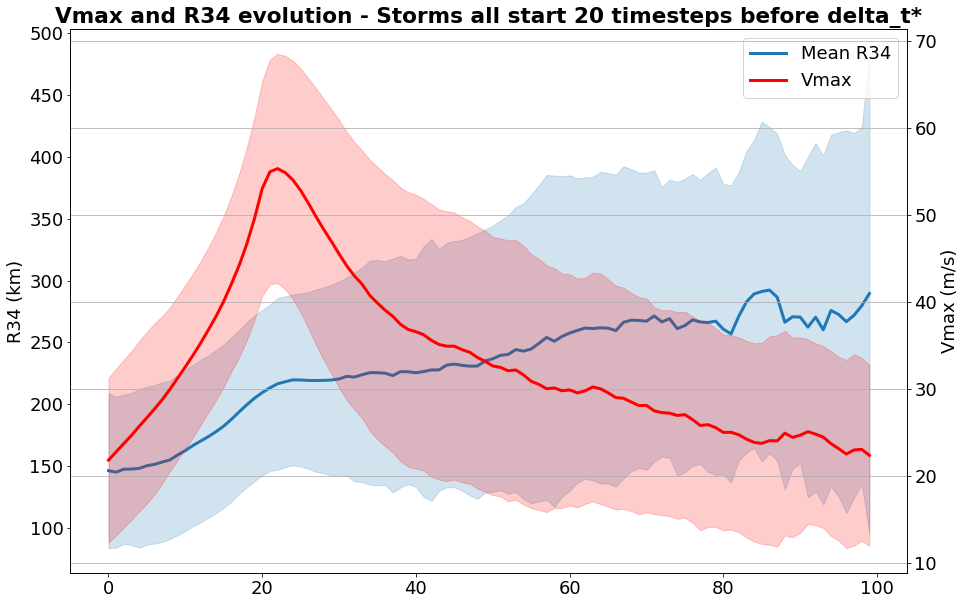

In [13]:
# Between t* and t* - 20 timesteps, where t* is the timestep when Vmax reaches 90% of max(Vmax)
r34_mean   = ds_final['mean_r34'].mean(dim='storm', skipna=True)
r34_std    = ds_final['mean_r34'].std(dim='storm', skipna=True)
vmax_mean  = ds_final['usa_wind'].mean(dim='storm', skipna=True)
vmax_std   = ds_final['usa_wind'].std(dim='storm', skipna=True)
rck22_mean = ds_final['mean_rmax_ck22'].mean(dim='storm', skipna=True)
rmax_mean  = ds_final['usa_rmw'].mean(dim='storm', skipna=True)
rmax_std   = ds_final['usa_rmw'].std(dim='storm', skipna=True)
fcor_mean  = ds_final['fcor'].mean(dim='storm', skipna=True)
Nr34quad_m =  ds_final['usa_r34'].count(dim='quadrant').mean(dim='storm')
Nr34quad_s =  ds_final['usa_r34'].count(dim='quadrant').std(dim='storm')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - Storms all start 20 timesteps before delta_t*', weight='bold')
l1  = ax1.plot(r34_mean, linewidth=3, c='tab:blue', label='Mean R34')
l2  = ax2.plot(vmax_mean, linewidth=3, c='r', label='Vmax')
ax1.fill_between(np.arange(len(r34_mean)), r34_mean + r34_std, r34_mean - r34_std, alpha=0.2, color='tab:blue')
ax2.fill_between(np.arange(len(vmax_mean)), vmax_mean + vmax_std, vmax_mean - vmax_std, alpha=0.2, color='r')
plt.xlabel('datetime');ax1.set_ylabel('R34 (km)');ax2.set_ylabel('Vmax (m/s)')
plt.grid();ax1.legend(l1 + l2, [l1[0].get_label(), l2[0].get_label()], loc=0)

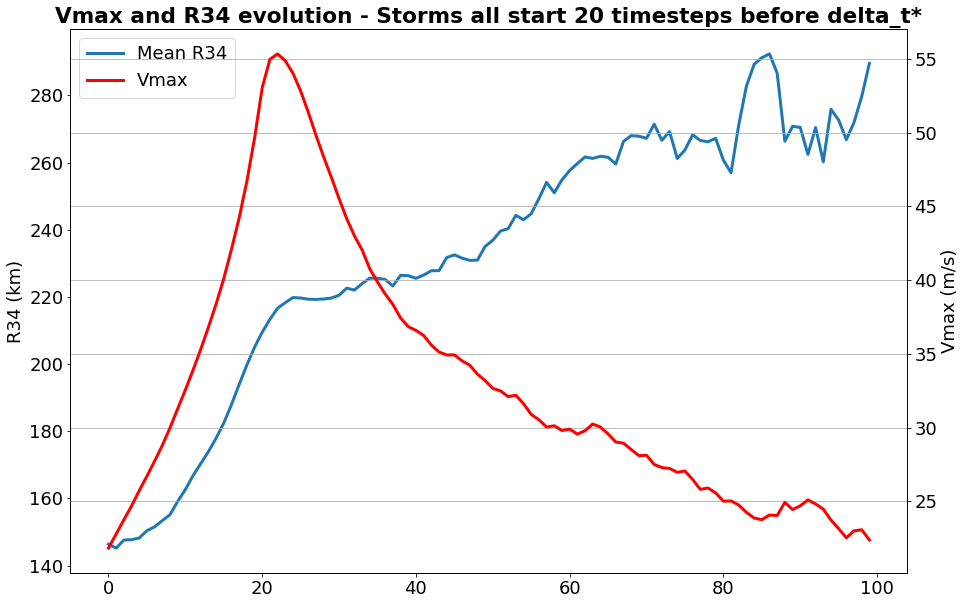

In [14]:
### SAME WITHOUT STD
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - Storms all start 20 timesteps before delta_t*', weight='bold')
l1  = ax1.plot(r34_mean, linewidth=3, c='tab:blue', label='Mean R34')
l2  = ax2.plot(vmax_mean, linewidth=3, c='r', label='Vmax')
plt.xlabel('datetime');ax1.set_ylabel('R34 (km)');ax2.set_ylabel('Vmax (m/s)')
plt.grid();ax1.legend(l1 + l2, [l1[0].get_label(), l2[0].get_label()], loc=0)

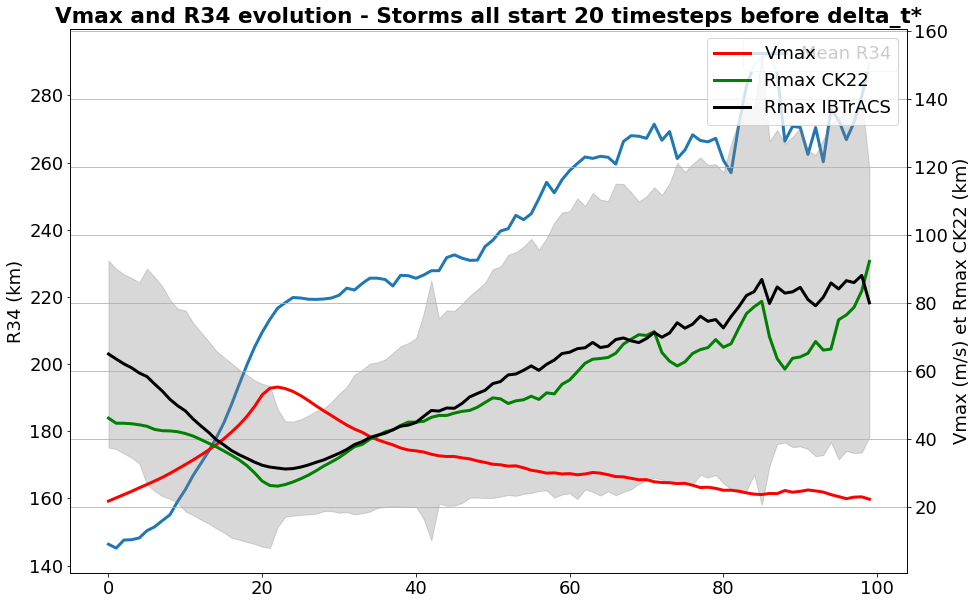

In [15]:
### SAME WITHOUT STD
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - Storms all start 20 timesteps before delta_t*', weight='bold')
l1  = ax1.plot(r34_mean, linewidth=3, c='tab:blue', label='Mean R34')
l2  = ax2.plot(vmax_mean, linewidth=3, c='r', label='Vmax')
ax2.plot(rck22_mean, linewidth=3, c='g', label='Rmax CK22')
ax2.plot(rmax_mean, linewidth=3, c='k', label='Rmax IBTrACS')
ax2.fill_between(np.arange(len(rmax_mean)), rmax_mean + rmax_std, rmax_mean - rmax_std, alpha=0.3, color='grey')
ax2.legend(loc=0);ax1.legend(loc=1)
plt.xlabel('datetime');ax1.set_ylabel('R34 (km)');ax2.set_ylabel('Vmax (m/s) et Rmax CK22 (km)')
plt.grid()

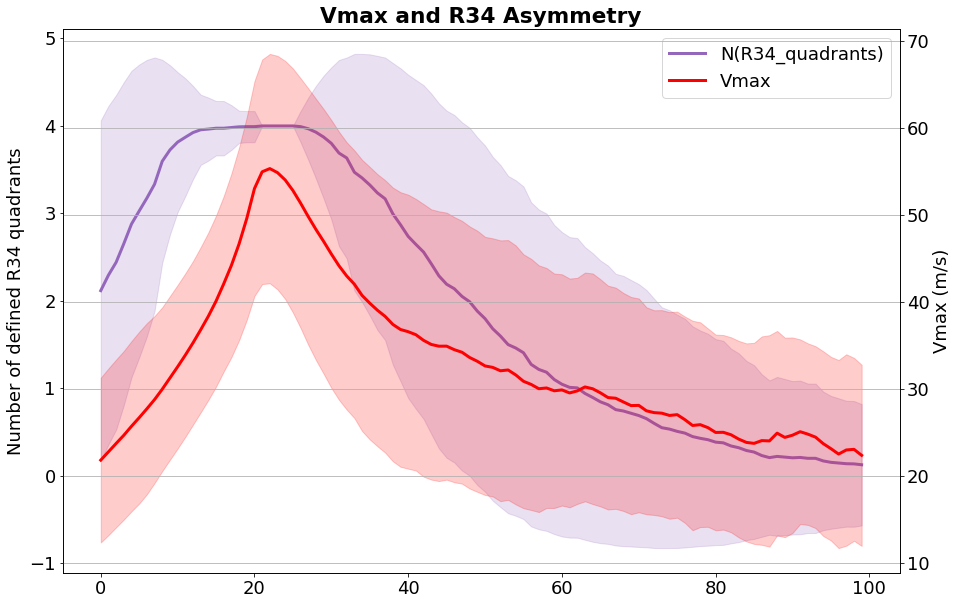

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 Asymmetry', weight='bold')
l1  = ax1.plot(Nr34quad_m, linewidth=3, c='tab:purple', label='N(R34_quadrants)')
l2  = ax2.plot(vmax_mean, linewidth=3, c='r', label='Vmax')
ax1.fill_between(np.arange(len(Nr34quad_m)), Nr34quad_m + Nr34quad_s, Nr34quad_m - Nr34quad_s, alpha=0.2, color='tab:purple')
ax2.fill_between(np.arange(len(vmax_mean)), vmax_mean + vmax_std, vmax_mean - vmax_std, alpha=0.2, color='r')
plt.xlabel('datetime');ax1.set_ylabel('Number of defined R34 quadrants');ax2.set_ylabel('Vmax (m/s)')
plt.grid();ax1.legend(l1 + l2, [l1[0].get_label(), l2[0].get_label()], loc=0)

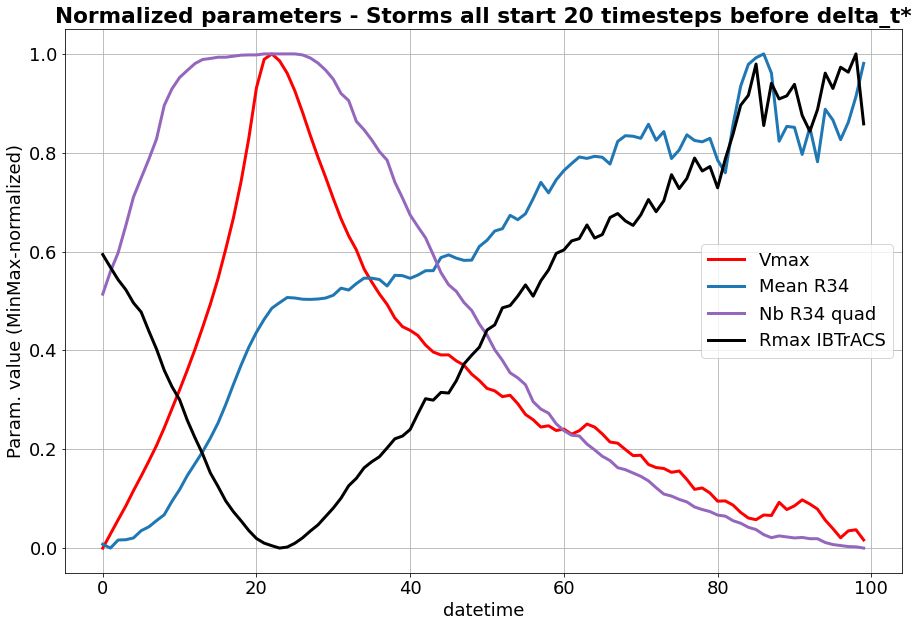

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

### NORMALIZED PARAMETERS
fig, ax1 = plt.subplots()
plt.title('Normalized parameters - Storms all start 20 timesteps before delta_t*', weight='bold')
plt.plot(scaler.fit_transform(np.expand_dims(np.array(vmax_mean), axis=1)),     linewidth=3, c='r',          label='Vmax')
plt.plot(scaler.fit_transform(np.expand_dims(np.array(r34_mean), axis=1)),      linewidth=3, c='tab:blue',   label='Mean R34')
plt.plot(scaler.fit_transform(np.expand_dims(np.array(Nr34quad_m), axis=1)),  linewidth=3, c='tab:purple', label='Nb R34 quad')
plt.plot(scaler.fit_transform(np.expand_dims(np.array(rmax_mean), axis=1)),     linewidth=3, c='k',          label='Rmax IBTrACS')
plt.xlabel('datetime');plt.ylabel('Param. value (MinMax-normalized)')
plt.grid();plt.legend()

In [18]:
# plt.hist(ds_final.v_star)

In [19]:
### BY CATEGORY
# for (interval, ds_vstar) in ds_final.groupby_bins(ds_final.v_star, bins=[33, 42, 49, 58, 70, 90]):
#     # print('V_star > {} m/s: {} samples'.format(int(interval.left), len(ds_vstar.storm)))
#     r34_vs = ds_vstar['mean_r34'].mean(dim='storm', skipna=True)
#     vmx_vs = ds_vstar['usa_wind'].mean(dim='storm', skipna=True)
#     rmx_vs = ds_vstar['usa_rmw'].mean(dim='storm', skipna=True)
#     N34_vs = ds_vstar['usa_r34'].count(dim='quadrant').mean(dim='storm')
    
#     ### NORMALIZED PARAMETERS
#     fig, ax1 = plt.subplots()
#     plt.title('{} < LMI < {} m/s: {} samples'.format(int(interval.left), int(interval.right), len(ds_vstar.storm)), weight='bold')
#     plt.plot(scaler.fit_transform(np.expand_dims(np.array(vmx_vs), axis=1)), linewidth=3, c='r',          label='Vmax')
#     plt.plot(scaler.fit_transform(np.expand_dims(np.array(r34_vs), axis=1)), linewidth=3, c='tab:blue',   label='Mean R34')
#     plt.plot(scaler.fit_transform(np.expand_dims(np.array(N34_vs), axis=1)), linewidth=3, c='tab:purple', label='Nb R34 quad')
#     plt.plot(scaler.fit_transform(np.expand_dims(np.array(rmx_vs), axis=1)), linewidth=3, c='k',          label='Rmax IBTrACS')
#     plt.xlabel('datetime');plt.ylabel('Param. value (MinMax-normalized)')
#     plt.grid();plt.legend();plt.show()

In [20]:
### TEST
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# plt.title('Storms all start 20 timesteps before delta_t*', weight='bold')
# l1  = ax1.plot(r34_mean / vmax_mean, linewidth=3, c='tab:blue', label='Mean R34 / Vmax')
# l2  = ax2.plot(vmax_mean, linewidth=3, c='r', label='Vmax')
# plt.plot(r34_mean, linewidth=3, c='tab:green', label='Mean R34')
# ax2.legend(loc=2);ax1.legend(loc=1)
# plt.grid()

### Individual samples

In [21]:
# for s in range(-10, -1):
#     ds = ds_final.isel(storm=s)
#     fig, ax1 = plt.subplots()
#     ax2 = ax1.twinx()
#     plt.title('{}, {}'.format(ds['name'].item().item(), ds['sid'].item().item()[:4]), weight='bold')
#     l1  = ax1.plot(ds['usa_wind'], linewidth=3, c='r', label='Vmax')
#     ax1.plot(ds['usa_rmw'], linewidth=3, c='k', label='Rmax IBTrACS')
#     l2  = ax2.plot(ds['mean_r34'], linewidth=3, c='tab:blue', label='R34')
#     ax2.legend(loc=1);ax1.legend(loc=2)
#     plt.xlabel('datetime');ax1.set_ylabel('Vmax (m/s) et Rmax (km)');ax2.set_ylabel('R34 (km)')
#     plt.xlim(-1, 100)
#     plt.axvline(x=20, c='r', linestyle='dashed')
#     plt.grid();plt.show()

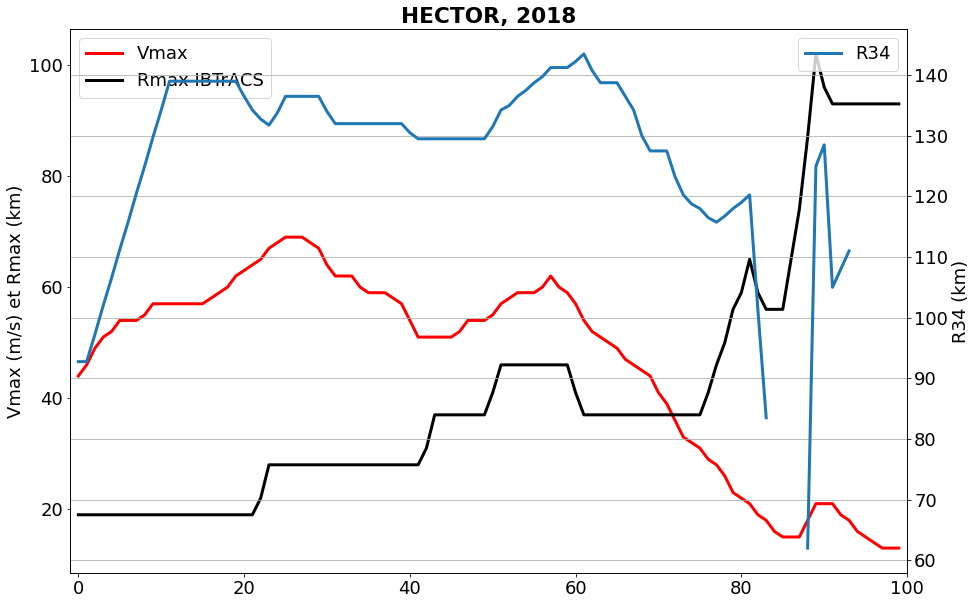

In [22]:
# HECTOR 2018
ds = ds_final.where(ds_final['name'] == 'HECTOR', drop=True).isel(storm=0)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('{}, {}'.format(ds['name'].item().item(), ds['sid'].item().item()[:4]), weight='bold')
l1  = ax1.plot(ds['usa_wind'], linewidth=3, c='r', label='Vmax')
ax1.plot(ds['usa_rmw'], linewidth=3, c='k', label='Rmax IBTrACS')
l2  = ax2.plot(ds['mean_r34'], linewidth=3, c='tab:blue', label='R34')
ax2.legend(loc=1);ax1.legend(loc=2)
plt.xlabel('datetime');ax1.set_ylabel('Vmax (m/s) et Rmax (km)');ax2.set_ylabel('R34 (km)')
plt.xlim(-1, 100)
# plt.axvline(x=20, c='r', linestyle='dashed')
plt.grid();plt.show()

### Is Mmax/M17 linked to diff_R34 and diff_Vmax?

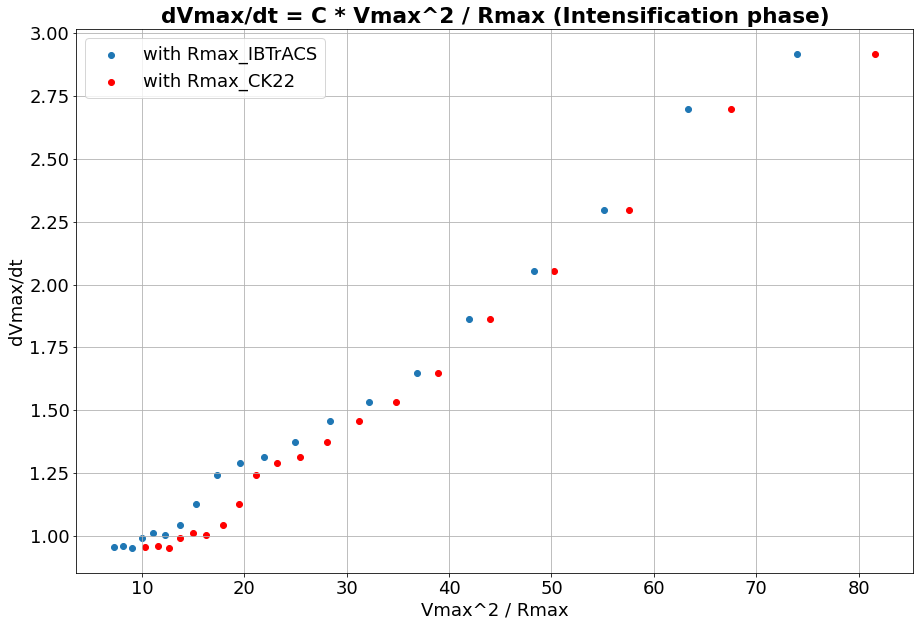

In [23]:
# Vmax_diff = C * Vmax ** 2 / Rmax on the 20 first timesteps
plt.title('dVmax/dt = C * Vmax^2 / Rmax (Intensification phase)', weight='bold')
plt.scatter(vmax_mean[:20] ** 2 / rmax_mean[:20],  np.gradient(vmax_mean[:20]), c='tab:blue', label='with Rmax_IBTrACS')
plt.scatter(vmax_mean[:20] ** 2 / rck22_mean[:20], np.gradient(vmax_mean[:20]), c='r', label='with Rmax_CK22')
plt.xlabel('Vmax^2 / Rmax');plt.ylabel('dVmax/dt')
plt.legend();plt.grid()

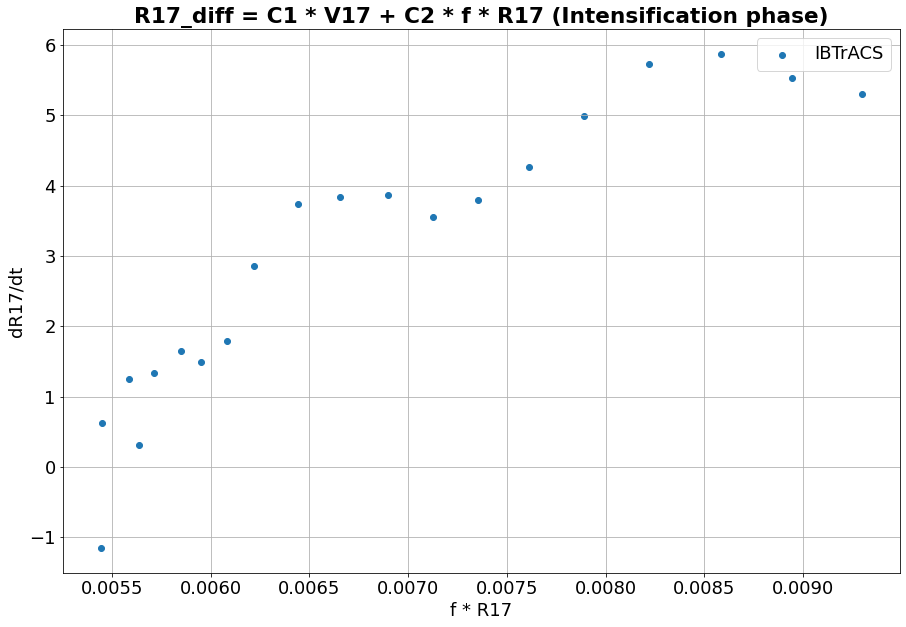

In [24]:
# R17_diff = C1 + C2 * f * R17 on the 20 first timesteps
plt.title('R17_diff = C1 * V17 + C2 * f * R17 (Intensification phase)', weight='bold')
plt.scatter(fcor_mean[:20] * r34_mean[:20],  np.gradient(r34_mean[:20]), c='tab:blue', label='IBTrACS')
# plt.scatter(0.35 * 1e-4 * r34_mean[:20] ** 2,  np.gradient(r34_mean[:20]), c='r', label='IBTrACS')
# plt.scatter(vmax_mean[:20] ** 2 / rck22_mean[:20], np.gradient(vmax_mean[:20]), c='r', label='with Rmax_CK22')
plt.xlabel('f * R17');plt.ylabel('dR17/dt')
plt.legend();plt.grid()

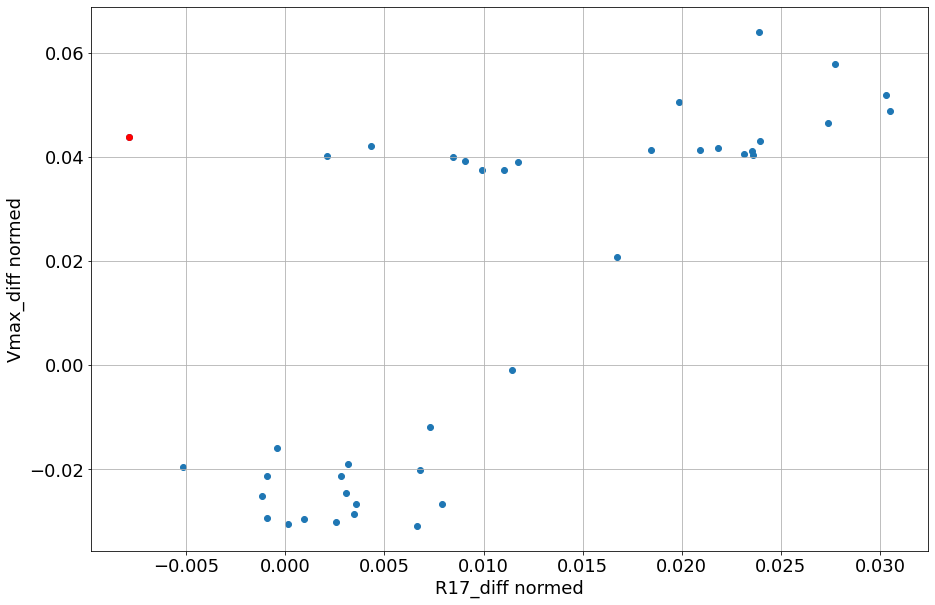

In [25]:
# plt.scatter(np.gradient(r34_mean[:20]) / r34_mean[:20], np.gradient(vmax_mean[:20]) / vmax_mean[:20], c='tab:blue', label='IBTrACS')
plt.scatter(np.gradient(r34_mean[:40]) / r34_mean[:40], np.gradient(vmax_mean[:40]) / vmax_mean[:40], c='tab:blue', label='IBTrACS')
plt.scatter(np.gradient(r34_mean)[0] / r34_mean[0], np.gradient(vmax_mean)[0] / vmax_mean[0], c='r', label='Start')
plt.xlabel('R17_diff normed');plt.ylabel('Vmax_diff normed')
plt.grid()

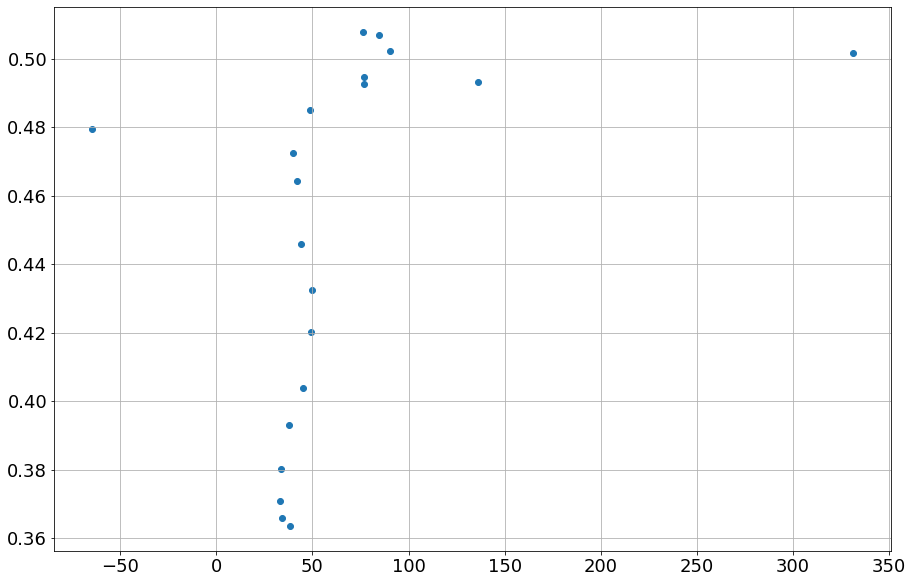

In [26]:
Mmax       = rmax_mean * 1000 * vmax_mean
M17        = r34_mean  * 1000 * 17.5      + 0.5 * fcor_mean * (r34_mean * 1000) ** 2
right_term = vmax_mean ** 3 / (np.gradient(vmax_mean) * np.gradient(r34_mean) * r34_mean)
plt.scatter(right_term[:20], (Mmax / M17)[:20]);plt.grid()

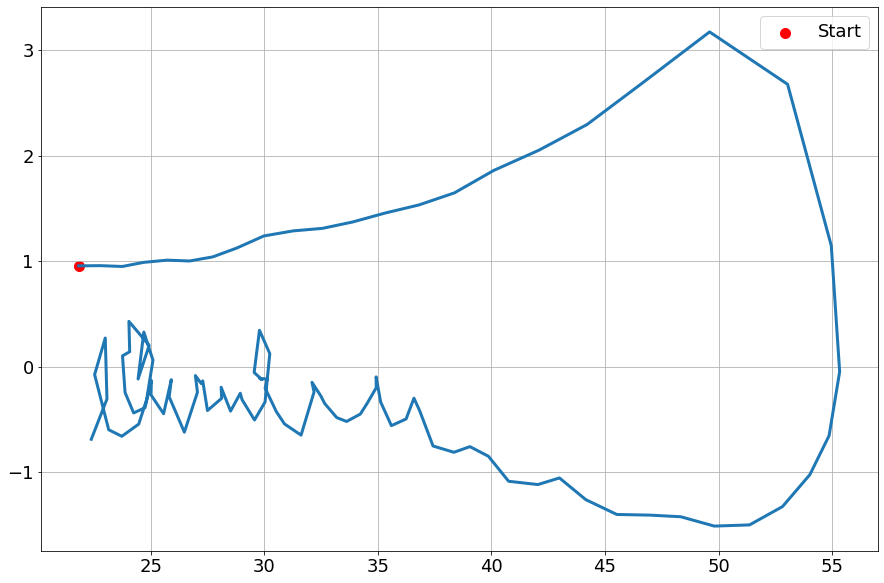

In [27]:
plt.plot(vmax_mean, np.gradient(vmax_mean), linewidth=3);plt.grid()
plt.scatter(vmax_mean[0], np.gradient(vmax_mean)[0], c='r', s=100, label='Start')
plt.legend()

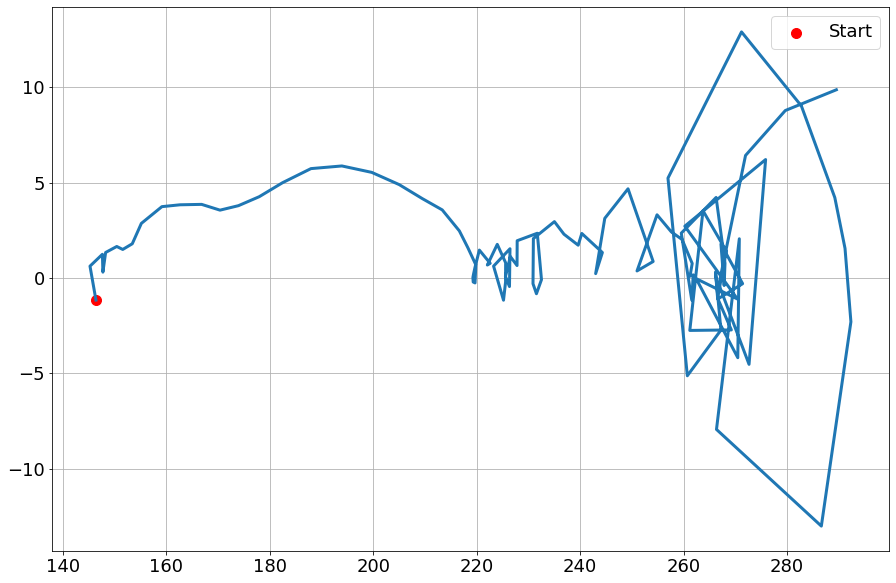

In [28]:
test = r34_mean
plt.plot(test, np.gradient(test), linewidth=3);plt.grid()
plt.scatter(test[0], np.gradient(test)[0], c='r', s=100, label='Start')
plt.legend()

### Ck/Cd analysis

In [29]:
def Ck_Cd_C15(x):
    return 0.00055 * x ** 2 - 0.0259 * x + 0.763

/home/arthur/scripts/TCsLifeMonitFromObs/functions.py:23: RuntimeWarning: invalid value encountered in power
  return (0.5 * Ck_Cd) ** (1 / (2 - Ck_Cd))


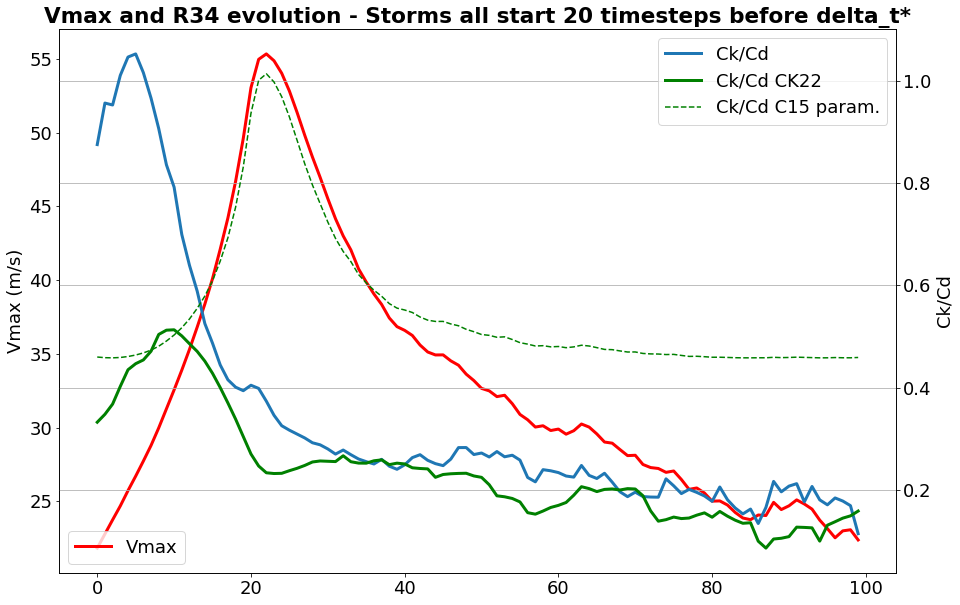

In [30]:
### Ck/Cd EVOLUTION
# Compute Ck/Cd with ER11 on the mean parameters
# NB: Computing Ck/Cd for every TC life cycles and then averaging is too time-consuming
fcor_abs            = np.abs(f.coriolis(ds_final['usa_lat']))
f_mean              = fcor_abs.mean(dim='storm', skipna=True)
ER11_SAR_ratio_mean = rmax_mean  * 1000 * vmax_mean / (r34_mean * 1000 * 17.5 + 0.5 * f_mean * ((r34_mean * 1000) ** 2))
ER11SRM_plus_rmax_s = (rmax_mean + rmax_std) * 1000 * vmax_mean / (r34_mean * 1000 * 17.5 + 0.5 * f_mean * ((r34_mean * 1000) ** 2))
ER11SRM_moin_rmax_s = (rmax_mean - rmax_std) * 1000 * vmax_mean / (r34_mean * 1000 * 17.5 + 0.5 * f_mean * ((r34_mean * 1000) ** 2))
ER11SRM_ck22        = rck22_mean * 1000 * vmax_mean / (r34_mean * 1000 * 17.5 + 0.5 * f_mean * ((r34_mean * 1000) ** 2))
Ck_Cd_mean          = f.fit_Ck_Cd_eq38(ER11_SAR_ratio_mean)
Ck_Cd_plus_s        = f.fit_Ck_Cd_eq38(ER11SRM_plus_rmax_s)
Ck_Cd_moin_s        = f.fit_Ck_Cd_eq38(ER11SRM_moin_rmax_s)
Ck_Cd_ck22          = f.fit_Ck_Cd_eq38(ER11SRM_ck22)

# # Verification of fitshape
# alpha = np.linspace(0.05, 1.5, 50)
# fun   = (0.5 * alpha) ** (1 / (2 - alpha))
# plt.title('Ck / Cd fit verification (colored by Rmax / R17)', weight='bold')
# plt.plot(alpha, fun, label='(0.5a) ^ 1 / (2 - a) where a = Ck / Cd')
# plt.grid();plt.legend()
# plt.xlabel('Fitted Ck / Cd');plt.ylabel('Rmax Vmax / (17.5 R17 + 0.5 f R17^2)')
# plt.scatter(Ck_Cd_mean, ER11_SAR_ratio_mean)

### SAME WITHOUT STD
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Vmax and R34 evolution - Storms all start 20 timesteps before delta_t*', weight='bold')
ax1.plot(vmax_mean, linewidth=3,  c='r', label='Vmax')
ax2.plot(Ck_Cd_mean, linewidth=3, c='tab:blue', label='Ck/Cd')
# ax2.fill_between(np.arange(len(Ck_Cd_mean)), Ck_Cd_plus_s, Ck_Cd_moin_s, alpha=0.3, color='tab:blue')
ax2.plot(Ck_Cd_ck22, linewidth=3, c='g',        label='Ck/Cd CK22')
ax2.plot(Ck_Cd_C15(vmax_mean), linestyle='--', c='g',        label='Ck/Cd C15 param.')
# ax2.plot(rmax_mean, linewidth=3, c='k', label='Rmax IBTrACS')
ax2.legend(loc=0);ax1.legend(loc=3)
plt.xlabel('datetime');ax2.set_ylabel('Ck/Cd');ax1.set_ylabel('Vmax (m/s)')
plt.grid()

### Is Ck/Cd SST-gradient-dependent?

In [31]:
### ASSIGN CK/CD
ds_final['ER11']  = ds_final['usa_rmw'] * 1000 * ds_final['usa_wind'] / (ds_final['mean_r34'] * 1000 * 17.5 + 0.5 * ds_final['fcor'] * ((ds_final['mean_r34'] * 1000) ** 2))
ds_final['ck_cd'] = ds_final['usa_rmw'] * 0
for s in tqdm(range(len(ds_final.storm))):
    ds = ds_final.isel(storm=s)
    for dt in range(len(ds.date_time)):
        dst   = ds.isel(date_time=dt)
        if dst['ER11'].notnull():
            ck_cd = f.fit_Ck_Cd_eq38(float(dst['ER11']))
            if ck_cd < 2.5:
                ds_final['ck_cd'][s, dt] = float(ck_cd)
            else:
                ds_final['ck_cd'][s, dt] = np.nan
        else:
            ds_final['ck_cd'][s, dt] = np.nan

  0%|          | 0/503 [00:00<?, ?it/s]

/home/arthur/scripts/TCsLifeMonitFromObs/functions.py:23: RuntimeWarning: invalid value encountered in power
  return (0.5 * Ck_Cd) ** (1 / (2 - Ck_Cd))


KeyboardInterrupt: 

In [ ]:
### ASSIGN BASIN AS STRING
ds_final['basin_as_str'] = ds_final['basin'][:, 0]
for s in tqdm(range(len(ds_final.storm))):
    ds = ds_final.isel(storm=s)
    for dt in range(len(ds.date_time)):
        bsn = ds['basin'][dt].item()
        if bsn != '':
            break
        else:
            continue
    ds_final['basin_as_str'][s] = bsn

In [ ]:
### CK/CD BY BASIN
fig, ax = plt.subplots()

ckcd_NAm = ds_final.where(ds_final['basin_as_str'] == 'NA', drop=True)['ck_cd'].mean(dim='storm', skipna=True)
ckcd_EPm = ds_final.where(ds_final['basin_as_str'] == 'EP', drop=True)['ck_cd'].mean(dim='storm', skipna=True)
ckcd_WPm = ds_final.where(ds_final['basin_as_str'] == 'WP', drop=True)['ck_cd'].mean(dim='storm', skipna=True)

ckcd_NAs = ds_final.where(ds_final['basin_as_str'] == 'NA', drop=True)['ck_cd'].std(dim='storm', skipna=True)
ckcd_EPs = ds_final.where(ds_final['basin_as_str'] == 'EP', drop=True)['ck_cd'].std(dim='storm', skipna=True)
ckcd_WPs = ds_final.where(ds_final['basin_as_str'] == 'WP', drop=True)['ck_cd'].std(dim='storm', skipna=True)

lenNA    = len(ds_final.where(ds_final['basin_as_str'] == 'NA', drop=True).storm)
lenEP    = len(ds_final.where(ds_final['basin_as_str'] == 'EP', drop=True).storm)
lenWP    = len(ds_final.where(ds_final['basin_as_str'] == 'WP', drop=True).storm)

plt.plot(ckcd_NAm, label='North Atlantic - {}'.format(lenNA), c='tab:blue')
plt.plot(ckcd_EPm, label='East Pacific - {}'.format(lenEP),   c='tab:orange')
plt.plot(ckcd_WPm, label='West Pacific - {}'.format(lenWP),   c='tab:green')

ax.fill_between(np.arange(len(ds_final.date_time)), ckcd_NAm - ckcd_NAs, ckcd_NAm + ckcd_NAs, color='tab:blue',   alpha=0.2)
ax.fill_between(np.arange(len(ds_final.date_time)), ckcd_EPm - ckcd_EPs, ckcd_EPm + ckcd_EPs, color='tab:orange', alpha=0.2)
ax.fill_between(np.arange(len(ds_final.date_time)), ckcd_WPm - ckcd_WPs, ckcd_WPm + ckcd_WPs, color='tab:green',  alpha=0.2)

plt.legend();plt.grid()
plt.xlabel('date_time')
plt.ylabel('Ck/Cd')

In [ ]:
plt.title('Ck/Cd distribution: 100 timesteps vs. 20 first time steps')
plt.hist(np.array(ds_final['ck_cd']).flatten(), label='All time steps', color='tab:blue', alpha=0.4, density=True)
plt.hist(np.array(ds_final.isel(date_time=slice(0, 20))['ck_cd']).flatten(), label='Intensifying phase', color='tab:orange', alpha=0.4, density=True)
plt.grid();plt.legend()

In [ ]:
ds_NA_int = ds_final.where(ds_final['basin_as_str'] == 'NA', drop=True).isel(date_time=slice(0, 20))
ds_EP_int = ds_final.where(ds_final['basin_as_str'] == 'EP', drop=True).isel(date_time=slice(0, 20))
# ds_WP_int = ds_final.where(ds_final['basin_as_str'] == 'WP', drop=True).isel(date_time=slice(0, 20))

prm = 'usa_wind'
plt.scatter(ds_NA_int[prm], ds_NA_int['ck_cd'], label='NA', c='tab:blue',   alpha=0.5)
plt.scatter(ds_EP_int[prm], ds_EP_int['ck_cd'], label='EP', c='tab:orange', alpha=0.5)
# plt.scatter(ds_WP_int[prm], ds_WP_int['ck_cd'], label='WP', c='tab:green',  alpha=0.2)
plt.xlabel(prm);plt.ylabel('Ck/Cd during intensifying phase')
plt.grid();plt.legend()

In [ ]:
ds_NA_int = ds_final.where(ds_final['basin_as_str'] == 'NA', drop=True).isel(date_time=slice(0, 20))
ds_EP_int = ds_final.where(ds_final['basin_as_str'] == 'EP', drop=True).isel(date_time=slice(0, 20))
# ds_WP_int = ds_final.where(ds_final['basin_as_str'] == 'WP', drop=True).isel(date_time=slice(0, 20))

prm = 'mean_r34'
plt.scatter(ds_NA_int[prm], ds_NA_int['ck_cd'], label='NA', c='tab:blue',   alpha=0.5)
plt.scatter(ds_EP_int[prm], ds_EP_int['ck_cd'], label='EP', c='tab:orange', alpha=0.5)
# plt.scatter(ds_WP_int[prm], ds_WP_int['ck_cd'], label='WP', c='tab:green',  alpha=0.2)
plt.xlabel(prm);plt.ylabel('Ck/Cd during intensifying phase')
plt.grid();plt.legend()

In [ ]:
ds_NA_int = ds_final.where(ds_final['basin_as_str'] == 'NA', drop=True).isel(date_time=slice(0, 20))
ds_EP_int = ds_final.where(ds_final['basin_as_str'] == 'EP', drop=True).isel(date_time=slice(0, 20))
# ds_WP_int = ds_final.where(ds_final['basin_as_str'] == 'WP', drop=True).isel(date_time=slice(0, 20))

prm = 'fcor'
plt.scatter(ds_NA_int[prm], ds_NA_int['ck_cd'], label='NA', c='tab:blue',   alpha=0.5)
plt.scatter(ds_EP_int[prm], ds_EP_int['ck_cd'], label='EP', c='tab:orange', alpha=0.5)
# plt.scatter(ds_WP_int[prm], ds_WP_int['ck_cd'], label='WP', c='tab:green',  alpha=0.2)
plt.xlabel(prm);plt.ylabel('Ck/Cd during intensifying phase')
plt.grid();plt.legend()

### Is Ck/Cd time-dependent?

#### Save csv files


In [ ]:
ds_int = ds_final.isel(date_time=slice(0, 20))
# Rmax selection
ds_int = ds_int.where(ds_int['usa_rmw'] < 50, drop=True)
# Latitude selection
ds_int = ds_int.where(ds_int['fcor'] < f.coriolis(20), drop=True)
# Outliers
ds_int = ds_int.where(ds_int['name'] != 'NADINE', drop=True) # NADINE (2012) reintensifies at the end of its life cycle, leading to very high timestep since 17.5 m/s
# NB: this is not the only example: Florence, Dorian, Winston... 
# Thus,  one possibility is to constrain this delay to be not too long:
# ds_int = ds_int.where(ds_int['timestep_since_17ms'] < 50)

In [ ]:
# ### SAVE CSV FILES
# def create_csv_file(ds, final_params=['usa_wind', 'usa_rmw', 'mean_rmax_ck22', 'mean_r34', 'fcor', 'u_trans', 'v_trans']):
#     # print('Creating dataset...')
#     X   = [] # shape (n_time, n_params)
#     fin_par_with_diff = final_params + ['{}_diff'.format(p) for p in final_params]
        
#     # Add derivatives
#     for p in final_params:
#         ds['{}_diff'.format(p)]     = ds[p] * np.nan
#         ds['{}_diff'.format(p)][1:] = ds[p].diff(dim='date_time')
#     # Get only valid stime steps
#     ds         = ds.dropna(dim='date_time', subset=fin_par_with_diff)

#     # Add to X and Y dataset
#     da         = ds[fin_par_with_diff].to_array().transpose()
#     for t in range(len(da['date_time'])):
#         X.append(da[t, :].values)
    
#     # Convert to arrays
#     X   = np.array(X)
#     return X

# ### SAVE CSV FILES - With Ck/Cd
# # ds_int_mean  = ds_int.mean(dim='quadrant', skipna=True)
# for s in tqdm(range(len(ds_int.storm))):
#     ds         = ds_int.isel(storm=s)
#     nme        = ds.where(ds['name'].notnull(), drop=True)['name'][0].item().item()
#     sid        = ds.where(ds['sid'].notnull(), drop=True)['sid'][0].item().item()
#     filename   = nme + '_' + sid
#     X_TC       = create_csv_file(ds, final_params=['usa_wind', 'usa_rmw', 'mean_rmax_ck22', 'mean_r34', 'fcor', 'u_trans', 'v_trans'])
#     if len(X_TC) > 0:
#         X_TC       = X_TC[:, [0, 1, 2, 3, 4, 5, 6]] # Select parameters
#         df         = pd.DataFrame(X_TC)
#         df.columns =  ['Vmax', 'Rmax_IBT', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']
#         df.to_csv(PATHS['save_csv_path'] + filename, index=False)

#### Ck/Cd dependencies

In [ ]:
# for prm in ['mean_r34', 'usa_rmw', 'usa_wind', 'fcor']:
#     plt.title('{} hist.'.format(prm))
#     plt.hist(np.array(ds_int[prm]).flatten())
#     plt.show()mean_rmax_ck22

In [ ]:
# plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
# cmap   = cm.get_cmap('gnuplot', 7)

# plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=ds_int['usa_wind'] * ds_int['usa_rmw'] / (ds_int['mean_r34']) , cmap=cmap, alpha=0.7)

# cbar = plt.colorbar()
# cbar.set_label('Vmax (m/s)', rotation=270)
# cbar.ax.get_yaxis().labelpad=25

# plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
# plt.grid()

In [ ]:
plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 7)

plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=ds_int['usa_wind'], cmap=cmap, alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('Vmax (m/s)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 7)

plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=ds_int['usa_wind'] / ds_int['v_star'], cmap=cmap, alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('Vmax / V*', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=ds_int['usa_rmw'], cmap=cmap, alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('Rmax (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=ds_int['mean_r34'], cmap=cmap, alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('R34 (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=ds_int['mean_r34'] / ds_int['initial_r17'], cmap=cmap, alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('Initial R34 / Current R34', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=ds_int['fcor'], cmap=cmap, alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('Coriolis parameter f (s-1)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=ds_int['v_star'], cmap=cmap, alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('Lifetime Maximum Intensity (m/s)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 7)
plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=np.log(ds_int['usa_wind'] / ds_int['mean_r34']), cmap=cmap, alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('Vmax / R34 (m/s/km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 4)
plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=ds_int['usa_r34'].count(dim='quadrant'), cmap=cmap, alpha=0.5)

cbar = plt.colorbar()
cbar.set_label('Nb of valid R34 quadrants', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
vmx_diff = xr.concat((ds_int['usa_wind'][:, 0:1], ds_int['usa_wind'].diff(dim='date_time')), dim='date_time')
r34_diff = xr.concat((ds_int['mean_r34'][:, 0:1], ds_int['mean_r34'].diff(dim='date_time')), dim='date_time')

plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
cmap   = cm.get_cmap('gnuplot', 7)
plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=np.log(ds_int['usa_wind'] ** 3 / (vmx_diff * r34_diff * ds_int['mean_r34'])), cmap=cmap, vmin=0, vmax=6, alpha=0.7)

cbar = plt.colorbar()
cbar.set_label('logarithm of Vmax^3 / (Vmax_diff * R34_diff * R34))', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
# cmap   = cm.get_cmap('gnuplot', 7)
# plt.scatter((ds_int['usa_wind'] ** 2) * ((ds_int['usa_rmw'] * 1000 ) ** 2) / ds_int['storm_speed'], ds_int['ck_cd'], c=ds_int['timestep_since_17ms'], vmin=10, vmax=40, cmap=cmap, alpha=0.7)
# cbar = plt.colorbar()
# cbar.ax.get_yaxis().labelpad=25
# plt.grid()

In [ ]:
du.plot_hist(ds_int['storm_speed'], bins=50)

In [ ]:
# plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
# cmap   = cm.get_cmap('gnuplot', 7)
# plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=np.log(vmx_diff), cmap=cmap, vmin=0.5, vmax=2, alpha=0.7)

# cbar = plt.colorbar()
# cbar.set_label('Vmax_idff', rotation=270)
# cbar.ax.get_yaxis().labelpad=25

# plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
# plt.grid()

In [ ]:
# plt.title('Ck/Cd dependency on time since storm reached Cat.1', weight='bold')
# cmap   = cm.get_cmap('gnuplot', 7)
# plt.scatter(ds_int['timestep_since_17ms'], ds_int['ck_cd'], c=np.log(r34_diff), cmap=cmap, vmin=0, vmax=4, alpha=0.7)

# cbar = plt.colorbar()
# cbar.set_label('R34_idff', rotation=270)
# cbar.ax.get_yaxis().labelpad=25

# plt.xlabel('time steps since storm reached 17.5 m/s');plt.ylabel('Ck/Cd')
# plt.grid()

In [ ]:
# Florence, dorian, winston
# ds_final.where(ds_final['name'] == 'FLORENCE', drop=True)['usa_wind'].plot();plt.grid()

In [ ]:
# ds = ds_int.where(ds_int['timestep_since_17ms'] > 50, drop=True)
# for s in range(len(ds.storm)):
#     ds.isel(storm=s)['usa_wind'].plot();plt.grid();plt.show()

#### Estimate Ck/Cd distribution - Part 1: Statistical diagnosis for parameters alone

In [ ]:
# plt.scatter(ds_int['usa_wind'], ds_int['ck_cd']);plt.show()
# plt.scatter(ds_int['usa_rmw'],  ds_int['ck_cd']);plt.show()
# plt.scatter(ds_int['usa_wind'] / ds_int['storm_speed'], ds_int['ck_cd']);plt.show()
# plt.scatter(ds_int['usa_rmw'] / ds_int['storm_speed'],  ds_int['ck_cd']);plt.show()

In [ ]:
# # R34 / t34
# plt.title('R34 divided by time since 34 knts', weight='bold')
# smll_t34 = arr_flat(ds_int.where(ds_int['timestep_since_17ms'] / ds_int['mean_r34'] <= 0.05, drop=True)['ck_cd'])
# medm_t34 = arr_flat(ds_int.where((ds_int['timestep_since_17ms'] / ds_int['mean_r34'] > 0.05) & (ds_int['timestep_since_17ms'] / ds_int['mean_r34'] < 0.15), drop=True)['ck_cd'])
# high_t34 = arr_flat(ds_int.where(ds_int['timestep_since_17ms'] / ds_int['mean_r34'] >= 0.15, drop=True)['ck_cd'])
# plt.hist(smll_t34, weights=weights(smll_t34),  color='tab:blue',  alpha=0.5, label='Smaller t34',  bins=nb_bins, edgecolor='k', linewidth=3)
# plt.hist(medm_t34, weights=weights(medm_t34),  color='tab:green', alpha=0.5, label='Medium t34',   bins=nb_bins)
# plt.hist(high_t34, weights=weights(high_t34),  color='tab:red',   alpha=0.5, label='High t34',     bins=nb_bins)
# plt.grid();plt.legend();plt.xlabel('Ck/Cd');plt.show()

In [ ]:
def weights(da):
    return np.ones_like(da) / np.count_nonzero(~np.isnan(da))
def arr_flat(da):
    return np.array(da).flatten()
nb_bins = 20

# Vmax
plt.title('Vmax', weight='bold')
smll_vmx = arr_flat(ds_int.where(ds_int['usa_wind'] <= 30, drop=True)['ck_cd'])
medm_vmx = arr_flat(ds_int.where((ds_int['usa_wind'] > 30) & (ds_int['usa_wind'] < 50), drop=True)['ck_cd'])
high_vmx = arr_flat(ds_int.where(ds_int['usa_wind'] >= 50, drop=True)['ck_cd'])
plt.hist(smll_vmx, weights=weights(smll_vmx),  color='tab:blue',  alpha=0.5, label='Smaller Vmax',  bins=nb_bins, edgecolor='k', linewidth=3)
plt.hist(medm_vmx, weights=weights(medm_vmx),  color='tab:green', alpha=0.5, label='Medium Vmax',   bins=nb_bins)
plt.hist(high_vmx, weights=weights(high_vmx),  color='tab:red',   alpha=0.5, label='High Vmax',     bins=nb_bins)
plt.grid();plt.legend();plt.xlabel('Ck/Cd');plt.show()

# R34
plt.title('R34', weight='bold')
smll_r34 = arr_flat(ds_int.where(ds_int['mean_r34'] <= 150, drop=True)['ck_cd'])
medm_r34 = arr_flat(ds_int.where((ds_int['mean_r34'] > 150) & (ds_int['mean_r34'] < 250), drop=True)['ck_cd'])
high_r34 = arr_flat(ds_int.where(ds_int['mean_r34'] >= 250, drop=True)['ck_cd'])
plt.hist(smll_r34, weights=weights(smll_r34),  color='tab:blue',  alpha=0.5, label='Smaller R34',  bins=nb_bins, edgecolor='k', linewidth=3)
plt.hist(medm_r34, weights=weights(medm_r34),  color='tab:green', alpha=0.5, label='Medium R34',   bins=nb_bins)
plt.hist(high_r34, weights=weights(high_r34),  color='tab:red',   alpha=0.5, label='High R34',     bins=nb_bins)
plt.grid();plt.legend();plt.xlabel('Ck/Cd');plt.show()

# f
plt.title('f', weight='bold')
smll_fcr = arr_flat(ds_int.where(ds_int['fcor'] <= 2.5e-5, drop=True)['ck_cd'])
medm_fcr = arr_flat(ds_int.where((ds_int['fcor'] > 2.5e-5) & (ds_int['fcor'] < 3.5e-5), drop=True)['ck_cd'])
high_fcr = arr_flat(ds_int.where(ds_int['fcor'] >= 3.5e-5, drop=True)['ck_cd'])
plt.hist(smll_fcr, weights=weights(smll_fcr),  color='tab:blue',  alpha=0.5, label='Smaller f',  bins=nb_bins, edgecolor='k', linewidth=3)
plt.hist(medm_fcr, weights=weights(medm_fcr),  color='tab:green', alpha=0.5, label='Medium f',   bins=nb_bins)
plt.hist(high_fcr, weights=weights(high_fcr),  color='tab:red',   alpha=0.5, label='High f',     bins=nb_bins)
plt.grid();plt.legend();plt.xlabel('Ck/Cd');plt.show()

# Time since 34 knts
plt.title('Time since 34 knts', weight='bold')
smll_t34 = arr_flat(ds_int.where(ds_int['timestep_since_17ms'] <= 10, drop=True)['ck_cd'])
medm_t34 = arr_flat(ds_int.where((ds_int['timestep_since_17ms'] > 10) & (ds_int['timestep_since_17ms'] < 30), drop=True)['ck_cd'])
high_t34 = arr_flat(ds_int.where(ds_int['timestep_since_17ms'] >= 30, drop=True)['ck_cd'])
plt.hist(smll_t34, weights=weights(smll_t34),  color='tab:blue',  alpha=0.5, label='Smaller t34',  bins=nb_bins, edgecolor='k', linewidth=3)
plt.hist(medm_t34, weights=weights(medm_t34),  color='tab:green', alpha=0.5, label='Medium t34',   bins=nb_bins)
plt.hist(high_t34, weights=weights(high_t34),  color='tab:red',   alpha=0.5, label='High t34',     bins=nb_bins)
plt.grid();plt.legend();plt.xlabel('Ck/Cd');plt.show()

# Rmax
plt.title('Rmax', weight='bold')
smll_rmx = arr_flat(ds_int.where(ds_int['usa_rmw'] <= 20, drop=True)['ck_cd'])
medm_rmx = arr_flat(ds_int.where((ds_int['usa_rmw'] > 20) & (ds_int['usa_rmw'] < 35), drop=True)['ck_cd'])
high_rmx = arr_flat(ds_int.where(ds_int['usa_rmw'] >= 35, drop=True)['ck_cd'])
plt.hist(smll_rmx, weights=weights(smll_rmx),  color='tab:blue',  alpha=0.5, label='Smaller Rmax',  bins=nb_bins, edgecolor='k', linewidth=3)
plt.hist(medm_rmx, weights=weights(medm_rmx),  color='tab:green', alpha=0.5, label='Medium Rmax',   bins=nb_bins)
plt.hist(high_rmx, weights=weights(high_rmx),  color='tab:red',   alpha=0.5, label='High Rmax',     bins=nb_bins)
plt.grid();plt.legend();plt.xlabel('Ck/Cd');plt.show()

# # Storm speed
# plt.title('Storm speed', weight='bold')
# smll_vts = arr_flat(ds_int.where(ds_int['storm_speed'] <= 3, drop=True)['ck_cd'])
# medm_vts = arr_flat(ds_int.where((ds_int['storm_speed'] > 3) & (ds_int['storm_speed'] < 6), drop=True)['ck_cd'])
# high_vts = arr_flat(ds_int.where(ds_int['storm_speed'] >= 6, drop=True)['ck_cd'])
# plt.hist(smll_vts, weights=weights(smll_vts),  color='tab:blue',  alpha=0.5, label='Smaller Storm speed',  bins=nb_bins, edgecolor='k', linewidth=3)
# plt.hist(medm_vts, weights=weights(medm_vts),  color='tab:green', alpha=0.5, label='Medium Storm speed',   bins=nb_bins)
# plt.hist(high_vts, weights=weights(high_vts),  color='tab:red',   alpha=0.5, label='High Storm speed',     bins=nb_bins)
# plt.grid();plt.legend();plt.xlabel('Ck/Cd');plt.show()

In [ ]:
# Time since 34 knts when other parameters are held ~constant
ds_hold = ds_int.where((ds_int['usa_wind'] > 35) & (ds_int['usa_wind'] < 42)\
                       & (ds_int['mean_r34'] > 145.) & (ds_int['mean_r34'] < 175.)\
                       & (ds_int['fcor'] > 2e-5) & (ds_int['fcor'] < 4e-5)\
                       , drop=True)
print('Nb of samples: {}'.format(len(ds_hold.storm)))

plt.title('Time since 34 knts when other parameters are held ~constant', weight='bold')
smll_t34 = arr_flat(ds_hold.where(ds_hold['timestep_since_17ms'] <= 12, drop=True)['ck_cd'])
medm_t34 = arr_flat(ds_hold.where((ds_hold['timestep_since_17ms'] > 12) & (ds_hold['timestep_since_17ms'] < 20), drop=True)['ck_cd'])
high_t34 = arr_flat(ds_hold.where(ds_hold['timestep_since_17ms'] >= 20, drop=True)['ck_cd'])
plt.hist(smll_t34, weights=weights(smll_t34),  color='tab:blue', alpha=0.5, label='Smaller t34',  bins=nb_bins, edgecolor='k', linewidth=3)
plt.hist(medm_t34, weights=weights(medm_t34),  color='tab:green', alpha=0.5, label='Medium t34',   bins=nb_bins)
plt.hist(high_t34, weights=weights(high_t34),  color='tab:red',  alpha=0.5, label='High t34',     bins=nb_bins)
plt.grid();plt.legend();plt.xlabel('Ck/Cd');plt.show()

print(np.count_nonzero(~np.isnan(smll_t34)))
print(np.count_nonzero(~np.isnan(medm_t34)))
print(np.count_nonzero(~np.isnan(high_t34)))

In [ ]:
### CLIMATOLOGICAL R34
mask = (np.isnan(ds_int['usa_wind'])) | (np.isnan(ds_int['mean_r34']))

vmax = np.expand_dims(np.array(ds_int['usa_wind'])[~mask].flatten(), axis=1)
vmx2 = np.expand_dims(np.array(ds_int['usa_wind'] ** 2)[~mask].flatten(), axis=1)
y    = np.expand_dims(np.array(ds_int['mean_r34'])[~mask].flatten(), axis=1)
X    = np.concatenate((vmax, vmx2), axis=1)

reg = LinearRegression().fit(X, y)

xs   = np.linspace(np.min(vmax), np.max(vmax), 100)
Xs   = np.concatenate((np.expand_dims(xs, axis=1), np.expand_dims(xs ** 2, axis=1)), axis=1)
yreg = reg.predict(Xs)

plt.title('Determining a climatological R34', weight='bold')
plt.scatter(ds_int['usa_wind'], ds_int['mean_r34'], label='Best-Tracks')
plt.plot(xs, yreg, c='r', linewidth=2, label='Reg: R34 = {:.2f} Vmax + {:.2f} Vmax^2 + {:.2f}'.format(reg.coef_[0][0], reg.coef_[0][1], float(reg.intercept_)))
plt.xlabel('Vmax (m/s)');plt.ylabel('R34 (km)');plt.grid();plt.legend()

In [ ]:
def get_msk_arr(da, msk):
    return  np.expand_dims(np.array(da)[~msk].flatten(), axis=1)

r34_r34c = y / reg.predict(X)
# plt.hist(r34_r34c)

plt.title('Ck/Cd dependency on R34/R34clim', weight='bold')
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(r34_r34c, get_msk_arr(ds_int['ck_cd'], mask), c=get_msk_arr(ds_int['usa_rmw'], mask), cmap=cmap, alpha=0.9)

cbar = plt.colorbar()
cbar.set_label('Rmax (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('R34 / R34clim');plt.ylabel('Ck/Cd')
plt.axvline(x=1, c='k')
plt.grid()

# ds_int['rmax_ck22'].mean(dim='quadrant')
# ds_int['usa_rmw']

In [ ]:
plt.title('Ck/Cd dependency on R34 / Vmax', weight='bold')
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(ds_int['mean_r34'] * 1000 / ds_int['usa_wind'] , ds_int['ck_cd'], c=ds_int['usa_rmw'], cmap=cmap, alpha=0.9)

cbar = plt.colorbar()
cbar.set_label('Rmax (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('R34 / Vmax (s)');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(get_msk_arr(ds_int['timestep_since_17ms'], mask), r34_r34c, c=get_msk_arr(ds_int['usa_rmw'], mask), cmap=cmap, alpha=0.9)

cbar = plt.colorbar()
cbar.set_label('Rmax (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time since 34 kts');plt.ylabel('R34/R34clim')
plt.grid()

# ds_int['rmax_ck22'].mean(dim='quadrant')
# ds_int['usa_rmw']

In [ ]:
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(ds_int['timestep_since_17ms'], ds_int['mean_r34'] * 1000 / ds_int['usa_wind'], c=ds_int['usa_rmw'], cmap=cmap, alpha=0.9)

cbar = plt.colorbar()
cbar.set_label('Rmax (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('time since 34 kts');plt.ylabel('R34 / Vmax')
plt.grid()

In [ ]:
### ESTIMATE CK/CD DISTRIBUTION USING R34/R34c
du.plot_hist(ds_int['mean_r34'])


In [ ]:
### John's idea
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter((ds_int['mean_r34'] * 1000) / np.sqrt(ds_int['usa_wind'] * ds_int['storm_speed']) , ds_int['ck_cd'], c=ds_int['usa_rmw'], cmap=cmap, alpha=0.9)

cbar = plt.colorbar()
cbar.set_label('Rmax (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('R34 / sqrt(Vtrans * Vmax)');plt.ylabel('Ck/Cd')
plt.grid()

In [ ]:
### With a 24hr delay
ds_int_afr = ds_int.isel(date_time=slice(8, 20))
ds_int_bfr = ds_int.isel(date_time=slice(0, 12))

cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter((ds_int_bfr['mean_r34'] * 1000) / np.sqrt(ds_int_bfr['usa_wind'] * ds_int_bfr['storm_speed']), ds_int_afr['ck_cd'], c=ds_int_afr['usa_rmw'], cmap=cmap, alpha=0.9)

cbar = plt.colorbar()
cbar.set_label('Rmax (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('R34 / sqrt(Vtrans * Vmax)');plt.ylabel('Ck/Cd 24hr after')
plt.grid()

In [ ]:
### With integrated quantity
ds_int_bfr['integrated_twv'] = ds_int_bfr['usa_wind'] * 0
for dt in tqdm(range(len(ds_int_bfr.date_time))):
    ds = ds_int.isel(date_time=slice(dt, dt + 8))
    qty     = (ds['mean_r34'] * 1000) / np.sqrt(ds['usa_wind'] * ds['storm_speed'])
    qty_igd = qty.fillna(0).integrate(coord='date_time')
    ds_int_bfr['integrated_twv'][:, dt] = qty_igd
    
# Plot
cmap   = cm.get_cmap('gnuplot', 5)
plt.scatter(ds_int_bfr['integrated_twv'], ds_int_afr['ck_cd'], c=ds_int_afr['usa_rmw'], cmap=cmap, alpha=0.9)

cbar = plt.colorbar()
cbar.set_label('Rmax (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('24H-integrated R34 / sqrt(Vtrans * Vmax)');plt.ylabel('Ck/Cd 24hr after')
plt.grid()

In [ ]:
du.plot_hist(ds_int['usa_wind'] / ds_int['v_star'])

In [ ]:
plt.title('IBTrACS', weight='bold')
cmap   = cm.get_cmap('coolwarm', 3)
plt.scatter(ds_int['usa_wind'], ds_int['usa_rmw'], c=ds_int['usa_wind'] / ds_int['v_star'], vmin=0.4, vmax=1, cmap=cmap, alpha=0.9)

cbar = plt.colorbar()
cbar.set_label('V / V*', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('Vmax (m/s)');plt.ylabel('Rmax (km)')
plt.xlim(20, 80);plt.ylim(5, 50);plt.grid()

In [ ]:
plt.title('IBTrACS + CK22', weight='bold')
cmap   = cm.get_cmap('coolwarm', 3)
plt.scatter(ds_int['usa_wind'], ds_int['mean_rmax_ck22'], c=ds_int['usa_wind'] / ds_int['v_star'], vmin=0.4, vmax=1, cmap=cmap, alpha=0.9)

cbar = plt.colorbar()
cbar.set_label('V / V*', rotation=270)
cbar.ax.get_yaxis().labelpad=25

plt.xlabel('Vmax (m/s)');plt.ylabel('Rmax CK22 (km)')
plt.xlim(20, 80);plt.ylim(5, 50);plt.grid()

#### Estimate Ck/Cd distribution - Part 2: Statistical diagnosis for combined parameters

In [ ]:
dsi_all = np.array(ds_int['ck_cd']).flatten()
dsi_eay = np.array(ds_int.where(ds_int['timestep_since_17ms'] < 10, drop=True)['ck_cd']).flatten()
dsi_mat = np.array(ds_int.where(ds_int['timestep_since_17ms'] > 30).where(ds_int['timestep_since_17ms'] < 40, drop=True)['ck_cd']).flatten()

In [ ]:
plt.hist(dsi_all, color='tab:blue',    density=True,            label='All',           bins=50)
plt.hist(dsi_eay, color='tab:gray',    density=True, alpha=0.5, label='Early storms',  bins=50)
plt.hist(dsi_mat, color='tab:orange', density=True,  alpha=0.5, label='Mature storms', bins=50)
plt.grid();plt.legend();plt.xlabel('Ck/Cd')

In [ ]:
# Logarithmic
plt.hist(np.log(dsi_all), color='tab:blue',    density=True,            label='All',           bins=50)
plt.hist(np.log(dsi_eay), color='tab:gray',    density=True, alpha=0.5, label='Early storms',  bins=50)
plt.hist(np.log(dsi_mat), color='tab:orange', density=True,  alpha=0.5, label='Mature storms', bins=50)
plt.grid();plt.legend();plt.xlabel('Ck/Cd')

In [ ]:
### ESTIMATE CK/CD DISTRIBUTION DURING INTENSIFICATION
# As a function of usa_wind, mean_r34, timestep_since_17ms, fcor
from collections import defaultdict

prms_global = ['usa_wind', 'mean_r34', 'timestep_since_17ms', 'fcor']
BINS = {
    'usa_wind':            [10, 30, 35, 40, 45, 50, 55, 60, 65, 80],
    'mean_r34':            [0, 50, 100, 150, 200, 250, 300, 350, 500],
    'timestep_since_17ms': [-5, 5, 10, 15, 20, 25, 30, 35, 40],
    'fcor':                np.array([0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) * 1e-5,
}

m_list = []
s_list = []
# PRMS = dict.fromkeys(prms_global, [])
PRMS = defaultdict(list)

bar = tqdm(total=np.prod([len(BINS[prm]) - 1 for prm in prms_global])) # Not the accurate total number because for certain value of fcor for instance, there will be only a few possible values of usa_wind. 

def loop_rec(prms, ds, bar, BINS=BINS):
    prm = prms[0]
    if len(prms) > 1:
        for interval, dsg in ds.groupby_bins(prm, BINS[prm]):
            loop_rec(prms[1:], dsg, bar)
    else:
        for interval, dsg in ds.groupby_bins(prm, BINS[prm]):
            bar.update(1)
            m_list.append(float(np.log(dsg.ck_cd).mean(skipna=True)))
            s_list.append(float(np.log(dsg.ck_cd).std(skipna=True)))
            for p in prms_global:
                PRMS[p].append(float(dsg[p].mean(skipna=True)))
                   
loop_rec(prms_global, ds_int, bar, BINS)

print('Total nb. of values: {}'.format(len(m_list)))

In [ ]:
### Regression is a bad idea... it would be better to use analogs
### For instance, for one given storm, take the 100-closest analogs. And compute m and s on the log(ck/cd) of these 100 storms.
# Prepare data
X   = np.concatenate([np.expand_dims(np.array(PRMS[prm]), axis=1) for prm in prms_global], axis=1)
y_m = np.array(m_list)
y_s = np.array(s_list)
# Mask NaN values
mask = np.isnan(y_m)
MASK = np.concatenate([np.expand_dims(np.array(mask), axis=1) for prm in prms_global], axis=1)
X_val= np.reshape(X[~MASK], (y_m[~mask].shape[0], X.shape[1]))

# Linear regression
regm = LinearRegression()
regm.fit(X_val, y_m[~mask])
regs = LinearRegression()
regs.fit(X_val, y_s[~mask])

In [ ]:
# plt.hist(PRMS['timestep_since_17ms'], density=True)
# plt.hist(np.array(ds_int['timestep_since_17ms']).flatten(), alpha=0.3, density=True)

In [ ]:
### BASIC EXAMPLE ON HECTOR 2018
# We just bin the dataset around the values of Hector
# Then we compute the mean and std of all Ck/Cd ratios of that dataset.
# We then assume that log(Ck/Cd) follows a normal distribution
# And we create the members for Ck/Cd accordinlgy. 
# Then, we will say that Ck/Cd follows a very simple dynamical model .
# e.g later in this notebook, Vmax ~ C1 * exp(a1 * t) and R17 /Rmax ~ C2 * exp(a2 * t) with a1 and a2 as close as possible
# We will use both our ensemble of possible Ck/Cd and our analytical model M to reconstruct Ck/Cd (and thus Rmax) at each time. 

hect = ds_int.where(ds_int['name'] == 'HECTOR', drop=True)
print('Vmax: ', float(hect['usa_wind'][0, 10]))
print('R34: ', float(hect['mean_r34'][0, 10]))
print('t34: ', float(hect['timestep_since_17ms'][0, 10]))
print('fcor: ', float(hect['fcor'][0, 10]))
print('Ck/Cd: ', float(hect['ck_cd'][0, 10]))

In [ ]:
### TEST
from scipy.stats import norm
h_vmx = 57
h_r34 = 134
h_t34 = 31
h_fcr = 3e-5

dsh = ds_int\
.where(ds_int['usa_wind'] > h_vmx - 5)\
.where(ds_int['usa_wind'] < h_vmx + 5)\
.where(ds_int['mean_r34'] > h_r34 - 50)\
.where(ds_int['mean_r34'] < h_r34 + 50)\
.where(ds_int['timestep_since_17ms'] > h_t34 - 5)\
.where(ds_int['timestep_since_17ms'] < h_t34 + 5)\
.where(ds_int['fcor'] > h_fcr - 2e-5)\
.where(ds_int['fcor'] < h_fcr + 2e-5, drop=True)

print(np.count_nonzero(~np.isnan(np.array(dsh['ck_cd']).flatten())))

m = np.log(dsh['ck_cd']).mean(skipna=True)
s = np.log(dsh['ck_cd']).std(skipna=True)

dist = norm(m, s)
print(float(m), float(s))
x = np.linspace(-6, 5, 50)
probs = dist.pdf(x)
plt.plot(x, probs)

plt.hist(np.log(np.array(dsh['ck_cd']).flatten()), density=True, stacked=True)

In [ ]:
np.exp(-0.9)

In [ ]:

plt.hist(np.log(dsi_all), density=True)
m = np.nanmean(np.log(dsi_all))
s = np.nanstd(np.log(dsi_all))
dist = norm(m, s)
x = np.linspace(-6, 5, 50)
probs = dist.pdf(x)
plt.plot(x, probs)

In [ ]:
from scipy.stats import norm
plt.hist(dsi_all, density=True)
plt.plot(x, probs)

In [ ]:
from scipy import stats
mask = np.isnan(dsi_all)
ae, loce, scalee = stats.skewnorm.fit(dsi_all[~mask])
p = stats.skewnorm.pdf(x,ae, loce, scalee)
plt.hist(dsi_all, bins=50, density=True, stacked=True, alpha=0.6, color='g')
plt.plot(x, p, 'k', linewidth=2)

In [ ]:
### TODO: Test significantivity of each of my predictors;
### Then estimate parameters distribution. 
### Also, what distribution is the closest to data?

### Put average Ck/Cd into AnDA

In [ ]:
# Build an "average" typical Ck/Cd profile (for AnDA)
cut_idx = 23
end_idx = 85

x    = np.arange(cut_idx, 100)
slope = (Ck_Cd_ck22[99] - Ck_Cd_ck22[cut_idx]) / (end_idx - cut_idx)
# plt.plot(slope * x)
Ck_Cd_ck22[cut_idx:] = Ck_Cd_ck22[cut_idx] + slope * x
plt.plot(Ck_Cd_ck22)

In [ ]:
# ### Allocate the mean CK_Cd to every profile
# ds_temp2 = ds_ibt.where(ds_ibt['delta_left_idx'] - ds_ibt['first_valid_idx'] >= 20, drop=True) # Delete sequences where end idx is lower than seq_len
# ds_temp2['mean_ck_cd'] = ds_temp2['usa_lon'] * 0 + 0.2

# for s in range(len(ds_temp2.storm)):
#     ds = ds_temp2.isel(storm=s)
#     ds_temp2['mean_ck_cd'][s, int(ds.delta_left_idx) - 20:int(ds.delta_left_idx) + 80] = Ck_Cd_ck22
 

In [ ]:
# ds_temp2.to_netcdf('/home/arthur/results/TCsLifeMonitFromObs/kalman/ds_ibt_ALL_with_mean_ck_cd')

In [ ]:
# ds_int['usa_wind'].mean(dim='storm', skipna=True).plot()
# (6 * (ds_int['mean_r34'] / ds_int['usa_rmw'])).mean(dim='storm', skipna=True).plot()

In [ ]:
# x = np.arange(len(rat))
# plt.plot(np.log(rat))
# plt.plot(1.5 * np.exp(x / 100))

In [ ]:
# (ds_int['usa_wind'] / ds_int['v_star']).mean(dim='storm', skipna=True).plot()
# (3 * ds_int['usa_rmw'] / ds_int['mean_r34']).mean(dim='storm', skipna=True).plot()

In [ ]:
# (ds_int['usa_wind'] / ds_int['v_star']).isel(storm=100).plot()
# (3 * ds_int['usa_rmw'] / ds_int['mean_r34']).isel(storm=100).plot()

In [ ]:
# from scipy.optimize import minimize

# # Idea: normalize by V_star to have adimensional numbers

# v   = ds_int['usa_wind'].mean(dim='storm', skipna=True).values
# rat = ds_int['usa_rmw'].mean(dim='storm', skipna=True).values

# def cost(prms):
#     c1, c2, a1, a2 = prms
#     t = np.arange(len(v))
#     C = sum(abs(np.log(v) - c1 - a1 * t) ** 2) + sum(abs(np.log(rat) - c2 - a2 * t)) + abs(a1 - a2) ** 2
#     return C

# x0  = [3.4, 1.5, 1 / 100, 1 / 100]

# res = minimize(cost, x0, method='Nelder-Mead', tol=1e-6)
# c1, c2, a1, a2 = res.x

# print(res.x)

# # Plot
# x   = np.arange(len(v))
# plt.plot(x, np.log(v),   label='log(Vmax) data', c='r')
# plt.plot(x, c1 + a1 * x, label='log(Vmax) analytical', c='r', linestyle='--')
# plt.plot(x, np.log(rat), label='log(Rmax) data', c='tab:blue')
# plt.plot(x, c2 + a2 * x, label='log(Rmax) analytical', c='tab:blue', linestyle='--')
# plt.legend();plt.grid()

In [ ]:
from scipy.optimize import minimize

# Idea: normalize by V_star to have adimensional numbers

v   = ds_int['usa_wind'].mean(dim='storm', skipna=True).values
rat = (ds_int['mean_r34'] / ds_int['usa_rmw']).mean(dim='storm', skipna=True).values

def cost(prms):
    c1, c2, a1, a2 = prms
    t = np.arange(len(v))
    C = sum(abs(np.log(v) - c1 - a1 * t) ** 2) + sum(abs(np.log(rat) - c2 - a2 * t)) + abs(a1 - a2) ** 2
    return C

x0  = [3.4, 1.5, 1 / 100, 1 / 100]

res = minimize(cost, x0, method='Nelder-Mead', tol=1e-6)
c1, c2, a1, a2 = res.x

print(res.x)

# Plot
x   = np.arange(len(v))
plt.plot(x, np.log(v),   label='log(Vmax) data', c='r')
plt.plot(x, c1 + a1 * x, label='log(Vmax) analytical', c='r', linestyle='--')
plt.plot(x, np.log(rat), label='log(R17/Rmax) data', c='tab:blue')
plt.plot(x, c2 + a2 * x, label='log(R17/Rmax) analytical', c='tab:blue', linestyle='--')
plt.legend();plt.grid()

In [ ]:
dsh = ds_int.isel(storm=-70)
print(dsh['name'][0].item())
vh   = np.array(dsh['usa_wind'])
rath = np.array(dsh['mean_r34'] / dsh['usa_rmw'])
x    = np.arange(len(vh))


plt.plot(x, np.log(vh),   label='log(Vmax) HECTOR', c='r')
plt.plot(x, c1 + a1 * x, label='log(Vmax) analytical', c='r', linestyle='--')
plt.plot(x, np.log(rath), label='log(R17/Rmax) HECTOR', c='tab:blue')
plt.plot(x, c2 + a2 * x, label='log(R17/Rmax) analytical', c='tab:blue', linestyle='--')
plt.legend();plt.grid()

In [ ]:
for s in range(300, 370):
    dsh = ds_int.isel(storm=s)
    print(dsh['name'][10].item())
    vh   = np.array(dsh['usa_wind'])
    rath = np.array(dsh['mean_r34'] / dsh['usa_rmw'])
    x    = np.arange(len(vh))


    plt.plot(x, np.log(vh),   label='log(Vmax)', c='r')
    plt.plot(x, c1 + a1 * x, label='log(Vmax) analytical', c='r', linestyle='--')
    plt.plot(x, np.log(rath), label='log(R17/Rmax)', c='tab:blue')
    plt.plot(x, c2 + a2 * x, label='log(R17/Rmax) analytical', c='tab:blue', linestyle='--')
    plt.legend();plt.grid();plt.show()

In [ ]:
### TEST
# da = (ds_int['usa_wind'] * (ds_int['mean_r34'] * 1000).differentiate(coord='date_time') - (ds_int['usa_rmw'] * 1000 * ds_int['usa_wind'].differentiate(coord='date_time'))) / ds_int['usa_wind']
da = (ds_int['usa_wind'] * (ds_int['mean_r34'] * 1000).differentiate(coord='date_time') - (ds_int['usa_rmw'] * 1000 * ds_int['usa_wind'].differentiate(coord='date_time'))) / ds_int['usa_wind']
for s in range(len(ds_int.storm)):
    plt.plot(da.isel(storm=s))
    # plt.show()

In [ ]:
# ### TEST
# # da = (ds_int['usa_wind'] * (ds_int['mean_r34'] * 1000).differentiate(coord='date_time') - (ds_int['usa_rmw'] * 1000 * ds_int['usa_wind'].differentiate(coord='date_time'))) / ds_int['usa_wind']
# da = ds_int['usa_wind'] * ((ds_int['usa_rmw'] * 1000) ** 2) / ((ds_int['mean_r34'] * 1000) ** 2) * (ds_int['mean_r34'] * 1000).differentiate(coord='date_time')
# for s in range(len(ds_int.storm))[:10]:
#     plt.plot(da.isel(storm=s))
#     plt.show()

In [ ]:
da.isel(storm=0)